In [1]:

import random
# import matplotlib.pyplot as plt
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
import pandas as pd

In [2]:
df = pd.read_csv('results.csv', header=1)

In [3]:
df.columns

Index(['Unnamed: 0', 'config', 'clean_reference', 'denoised_1', 'date', 'id',
       'testId', 'uuid', 'preffered_utterance', 'snr', 'time', 'type',
       'denoised_2'],
      dtype='object')

In [4]:
df_10 = df[df['snr']=='-10db']

In [5]:
df_10['preffered_utterance']

20       RegressionFCNN_SX49.WAV.n121.wav
27            SMoLnet_SI1129.WAV.n122.wav
33            SMoLnet_SI1129.WAV.n121.wav
36             SMoLnet_SX409.WAV.n121.wav
56           WaveUNet_SI1129.WAV.n121.wav
64               DPTNet_SX49.WAV.n121.wav
67              DPTNet_SX139.WAV.n122.wav
69              DCUNet_SX319.WAV.n121.wav
84              SMoLnet_SX49.WAV.n121.wav
87              DPTNet_SX139.WAV.n122.wav
89             SMoLnet_SX319.WAV.n121.wav
106      RegressionFCNN_SX49.WAV.n121.wav
112          WaveUNet_SI1759.WAV.n122.wav
121             DCUNet_SX139.WAV.n121.wav
125    RegressionFCNN_SI1129.WAV.n122.wav
129    RegressionFCNN_SI1759.WAV.n122.wav
132          WaveUNet_SI1759.WAV.n122.wav
136           SMoLnet_SI1759.WAV.n121.wav
139            WaveUNet_SX49.WAV.n121.wav
141           SMoLnet_SI1129.WAV.n122.wav
143             DPTNet_SX319.WAV.n122.wav
148          WaveUNet_SI1759.WAV.n122.wav
153            WaveUNet_SX49.WAV.n121.wav
155    RegressionFCNN_SI1759.WAV.n

In [6]:
prefered_10db = df_10['preffered_utterance'].apply(lambda x: x.split('_')[0])

<AxesSubplot:>

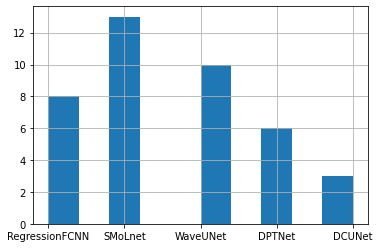

In [7]:
prefered_10db.hist()